# Compute geostrophic geopotential from u,v 

Usually one computes ug and vg from Phi. 
Here we compute Phi_g from u and v. 

Phi_g is the potential of vector field fu,fv. Use windspharm library. 

In [2]:
import xarray as xr 
import windspharm
import numpy as np
import matplotlib.pyplot as plt

# Do it in 4D, include a dp variable for integration later
### Select middle time (with dw/dt variable in it) as e53d

In [3]:
e54d = xr.open_dataset('/Users/bmapes/Box/era5_3D_3hours_20140916.nc')

# Calculate the derivative of the 'level' coordinate and assign it to a new data array 'dp'
dp_values = xr.DataArray(e54d['level'].differentiate('level'), dims=['level'], 
                         coords={'level': e54d['level']})
e54d['dp'] = dp_values*100./9.81  # dp/g for kg/m2 units 

In [4]:
# Calculate the time derivative of w and assign it to a new data array 'dwdt'
dwdt = xr.DataArray(e54d['w'].differentiate('time'))
e54d['dwdt'] = dwdt 

In [5]:
e53d = e54d.isel({'time':1})
e53d

<xarray.Dataset>
Dimensions:    (longitude: 1440, latitude: 721, level: 32)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * level      (level) int32 10 20 30 50 70 100 125 ... 875 900 925 950 975 1000
    time       datetime64[ns] 2014-09-16T11:00:00
Data variables:
    z          (level, latitude, longitude) float32 ...
    u          (level, latitude, longitude) float32 ...
    v          (level, latitude, longitude) float32 ...
    w          (level, latitude, longitude) float32 -0.005095 ... -0.004575
    dp         (level) float64 10.19 10.19 10.19 10.19 ... 10.19 10.19 10.19
    dwdt       (level, latitude, longitude) float32 6.858e-16 ... 1.083e-15
Attributes:
    Conventions:  CF-1.6
    history:      2023-10-06 01:50:47 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [6]:
u = e53d['u']
v = e53d['v']
Z = e53d['z']

## Compute global mean Z profile to add to hor. pattern of Zg

In [7]:
weights = np.cos(np.deg2rad(Z.latitude))
weights.name = "weights"
weights
globalZ = Z.weighted(weights).mean(("longitude", "latitude"))
globalZ

<xarray.DataArray 'z' (level: 32)>
array([302349.28  , 257759.98  , 232405.27  , 201076.25  , 180823.38  ,
       159762.98  , 146614.7   , 135693.81  , 126280.94  , 117981.68  ,
       110542.234 , 103780.2   ,  91779.77  ,  81284.47  ,  71911.336 ,
        63426.348 ,  55666.86  ,  48514.125 ,  41876.902 ,  35680.957 ,
        29866.123 ,  24386.674 ,  21761.252 ,  19206.842 ,  16719.904 ,
        14297.455 ,  11936.353 ,   9633.067 ,   7384.2964,   5186.6167,
         3037.2666,    933.7931], dtype=float32)
Coordinates:
  * level    (level) int32 10 20 30 50 70 100 125 ... 875 900 925 950 975 1000
    time     datetime64[ns] 2014-09-16T11:00:00

## Ready for geogeo (geostrophic geopotential)

In [8]:
#f = 2 Omega sin lat
Omega = 2*np.pi / 86164. #86400. # inverse second units, stellar day

# TEST! weaken Omega by 5% 

fu = u* 2*Omega * np.sin(u.latitude *np.pi/180.) 
fv = v* 2*Omega * np.sin(v.latitude *np.pi/180.) 

fV = windspharm.xarray.VectorWind(fu,fv)   # seems to work for all levels at once

Zg = fV.streamfunction() + globalZ
Za = (Z - Zg)

In [9]:
Z[1][9].level.values #200 hPa

array(20, dtype=int32)

Text(0.5, 1.0, 'gZa')

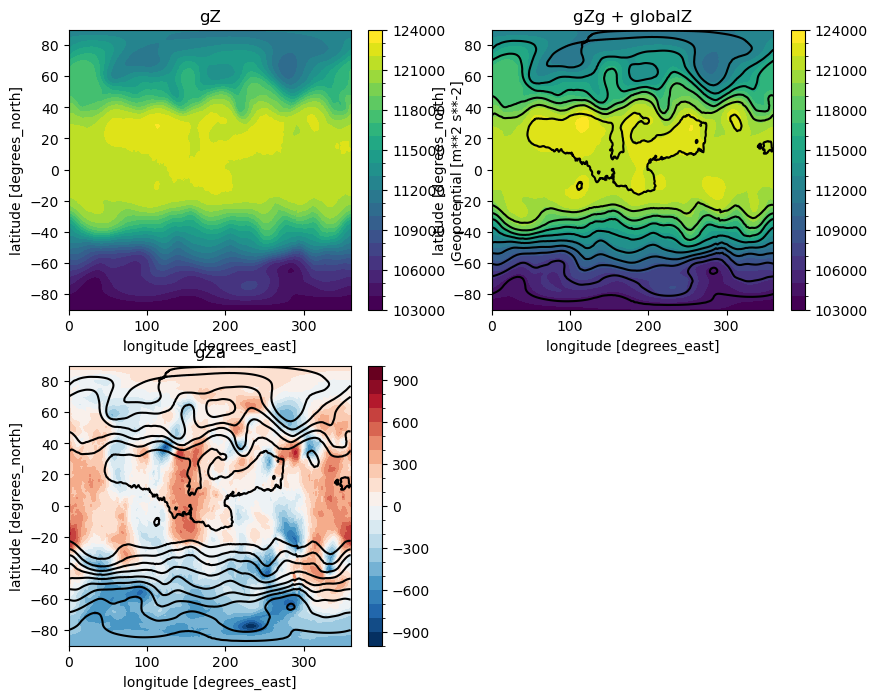

In [10]:
plt.figure(figsize=(10,8))

plt.subplot(2, 2, 1)
Z[9].plot.contourf(levels=25)
plt.title('gZ')

plt.subplot(2, 2, 2)
Zg[9].plot.contourf(levels=25)
Z[9].plot.contour(levels=13, colors='k')
plt.title('gZg + globalZ')

plt.subplot(2, 2, 3)
Za[9].plot.contourf(levels=25)
Z[9].plot.contour(levels=13, colors='k')
plt.title('gZa')


Text(0.5, 1.0, 'ageostrophic (shaded) and geostrophic (contours) gZ200')

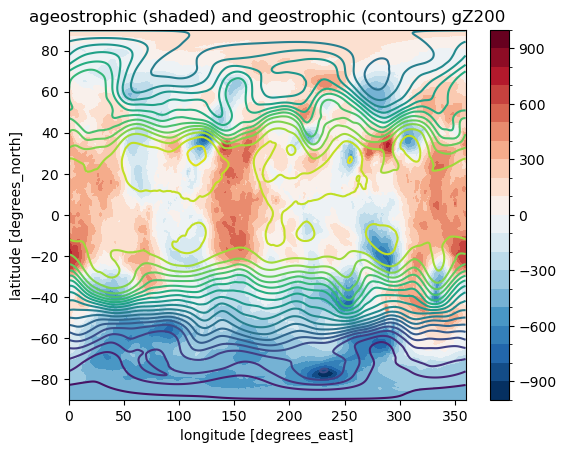

In [11]:
Za[9].plot.contourf(levels=25)
Zg[9].plot.contour(levels=25)

plt.title('ageostrophic (shaded) and geostrophic (contours) gZ200')

# For Hor. V Advection component, 
### instead of strf(fu,fv) WE want strf(-adv(v),adv(u)) 
just taking terms in analogous positions of u & v equations. I should recast this as "potentials" not "streamfunctions" for clarity, but am writing this in bashing-out mode at the moment

In [12]:
# gradient method is a property of any windspharm object, like fV 
# zonal and meridional gradients of u and v 
du_zon, du_mer = fV.gradient(u)
dv_zon, dv_mer = fV.gradient(v)

#modeling on fV = windspharm.xarray.VectorWind(fu,fv) 
# Vector of horizontal advective accelerations
hadvA = windspharm.xarray.VectorWind(
    (u*dv_zon + v*dv_mer),-(u*du_zon + v*du_mer) )
Zhadv = hadvA.streamfunction()

Text(0.5, 1.0, '-V.gradV component (shaded) and Zageo (contours)')

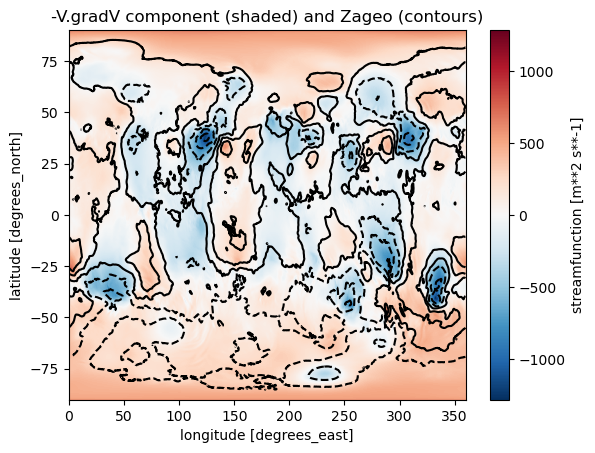

In [13]:
Zhadv[9].plot()
Za[9].plot.contour(levels=10,colors='k')
plt.title('-V.gradV component (shaded) and Zageo (contours)')

# Construct time-change component 
### instead of strf(fu,fv) use strf(dvdt,-dudt)

In [15]:
# gradient method is a property of any windspharm object, like fV 
# zonal and meridional gradients of u and v 
du_t = (e54d.u[2]-e54d.u[0]) /2./3600.  # acceleration units same as advection 
dv_t = (e54d.v[2]-e54d.v[0]) /2./3600.  # acceleration units same as advection 

#modeling on fV = windspharm.xarray.VectorWind(fu,fv) 
# Vector of accelerations, but taken over to RHS so sign flipped
accelA = windspharm.xarray.VectorWind(dv_t,-du_t)
Zacc = accelA.streamfunction()

Text(0.5, 1.0, 'Zaccel component (shaded) and Zageo (contours)')

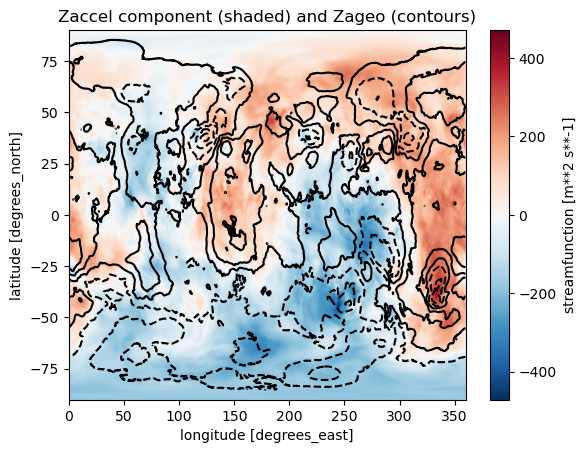

In [16]:
Zacc[9].plot()
Za[9].plot.contour(levels=10,colors='k')
plt.title('Zaccel component (shaded) and Zageo (contours)')

Text(0.5, 1.0, 'Zimb component (shaded) and Zageo (contours)')

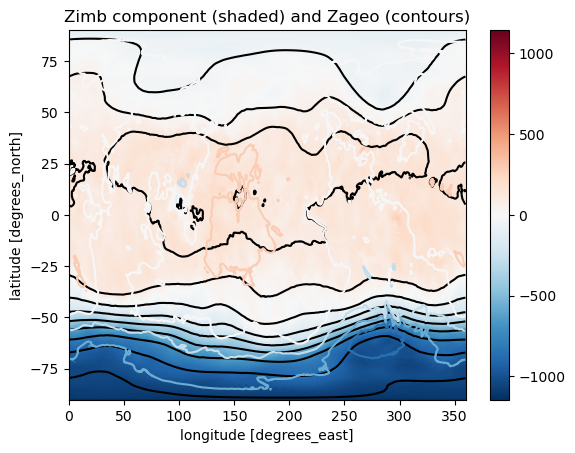

In [17]:
# Imbalance is friction, or vertical transport more generally

Zimb = Z - Zg - Zhadv - Zacc 

# One prooblem: is the Coriolis parameter too weak by about 5% ? 
# TEST: subtract 5% of Zg pattern. Yes indeed! At 200 mb.

#Zimb = Z - Zg - Zhadv - Zacc -0.05*(Zg-globalZ)[1]

Zimb[5].plot()
Z[5].plot.contour(levels=10,colors='k')
Za[5].plot.contour(levels=10)
plt.title('Zimb component (shaded) and Zageo (contours)')

# Downward integral of $\nabla^2 \Phi_{accel}$ is omega tendency 
Obviously going to be terribly noisy... truncate to T42 or something

In [1]:
e53d.dwdt[15].plot()

NameError: name 'e53d' is not defined

# Integrate LapZ fields downward to 1000mb and 500mb
### Have: Z, Zg, Za, Zhadv, Zacc, Zimb

In [23]:
Zob = Z

In [24]:
suffixes = ['ob','g','a','hadv','acc','imb']

In [25]:
for suf in suffixes: 
    doit = 'u'+suf+',v'+suf+' = fV.gradient(Z'+suf+')'
    print(doit)
    exec(doit)

uob,vob = fV.gradient(Zob)
ug,vg = fV.gradient(Zg)
ua,va = fV.gradient(Za)
uhadv,vhadv = fV.gradient(Zhadv)
uacc,vacc = fV.gradient(Zacc)
uimb,vimb = fV.gradient(Zimb)


In [ ]:
for suf in suffixes: 
    doit = 'A'+suf+' = windspharm.xarray.VectorWind(u'+suf+',v'+suf+')'
    print(doit)
    exec(doit)
    doit2 = 'Adiv'+suf+' = A'+suf+'.divergence(truncation=50)'
    print(doit2)
    exec(doit2)
    doit3 = 'dwdt'+suf+' =(Adiv'+suf+'*e53d.dp).cumsum()'
    print(doit3)
    exec(doit3)

Aob = windspharm.xarray.VectorWind(uob,vob)
Adivob = Aob.divergence(truncation=50)
dwdtob =(Adivob*e53d.dp).cumsum()
Ag = windspharm.xarray.VectorWind(ug,vg)
Adivg = Ag.divergence(truncation=50)
dwdtg =(Adivg*e53d.dp).cumsum()
Aa = windspharm.xarray.VectorWind(ua,va)
Adiva = Aa.divergence(truncation=50)
dwdta =(Adiva*e53d.dp).cumsum()
Ahadv = windspharm.xarray.VectorWind(uhadv,vhadv)


In [ ]:
Adivacc[10].plot()

# Integrate downward with cumsum

In [ ]:
(Adivhadv*e53d.dp)[:,400,800].plot()
#(Adiva*e53d.dp)[7:,300,300].plot()
#dwdtacc[:,300,300].plot()

In [ ]:
( (Adivhadv*e53d.dp)[0:,400,800].cumsum() - (Adivhadv*e53d.dp)[0:,300,300].sum()).plot()

In [27]:
# Augment e53d dataset and write it out 
dsout = e53d

In [30]:
e53d['dwdtg']=dwdtg
e53d

<xarray.Dataset>
Dimensions:    (longitude: 1440, latitude: 721, level: 32)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * level      (level) int32 10 20 30 50 70 100 125 ... 875 900 925 950 975 1000
    time       datetime64[ns] 2014-09-16T11:00:00
Data variables:
    z          (level, latitude, longitude) float32 3.028e+05 ... 655.9
    u          (level, latitude, longitude) float32 -0.001392 ... 0.001328
    v          (level, latitude, longitude) float32 -0.001298 ... 0.0008998
    w          (level, latitude, longitude) float32 -0.005095 ... -0.004575
    dp         (level) float64 10.19 10.19 10.19 10.19 ... 10.19 10.19 10.19
    dwdt       (level, latitude, longitude) float32 6.858e-16 ... 1.083e-15
    dwdtg      (level, latitude, longitude) float64 3.89e-08 ... 0.08976
Attributes:
    Conventions:  CF-1.6
    history:      2023-10-06 01:50:47 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [37]:
for suf in suffixes: 
    doit = "e53d['dwdt"+suf+"'] = dwdt"+suf
    doit2 = "e53d['Adiv"+suf+"'] = Adiv"+suf
    print(doit, doit2)
    exec(doit)
    exec(doit2)

e53d['dwdtob'] = dwdtob e53d['Adivob'] = Adivob
e53d['dwdtg'] = dwdtg e53d['Adivg'] = Adivg
e53d['dwdta'] = dwdta e53d['Adiva'] = Adiva
e53d['dwdthadv'] = dwdthadv e53d['Adivhadv'] = Adivhadv
e53d['dwdtacc'] = dwdtacc e53d['Adivacc'] = Adivacc
e53d['dwdtimb'] = dwdtimb e53d['Adivimb'] = Adivimb


In [36]:
e53d['dwdt'] = (e54d.w[2]-e54d.w[0])/3600. /2. 

In [38]:
e53d

<xarray.Dataset>
Dimensions:    (longitude: 1440, latitude: 721, level: 32)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * level      (level) int32 10 20 30 50 70 100 125 ... 875 900 925 950 975 1000
    time       datetime64[ns] 2014-09-16T11:00:00
Data variables: (12/18)
    z          (level, latitude, longitude) float32 3.028e+05 ... 655.9
    u          (level, latitude, longitude) float32 -0.001392 ... 0.001328
    v          (level, latitude, longitude) float32 -0.001298 ... 0.0008998
    w          (level, latitude, longitude) float32 -0.005095 ... -0.004575
    dp         (level) float64 10.19 10.19 10.19 10.19 ... 10.19 10.19 10.19
    dwdt       (level, latitude, longitude) float32 6.858e-07 ... 1.083e-06
    ...         ...
    Adivob     (level, latitude, longitude) float32 -4.867e-09 ... -6.397e-08
    Adivg      (level, latitude, longitude) float32 3.816e-09 ... -5.066e-09
    Adiva      (level, latitude, longitude) float32 -8.6e-09 ... -5.89e-08
    Adivhadv   (level, latitude, longitude) float32 -5.087e-09 ... -5.399e-09
    Adivacc    (level, latitude, longitude) float32 -6.481e-09 ... -7.973e-10
    Adivimb    (level, latitude, longitude) float32 2.968e-09 ... -5.27e-08
Attributes:
    Conventions:  CF-1.6
    history:      2023-10-06 01:50:47 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [39]:
e53d.to_netcdf('/Users/bmapes/Box/era5_3D_3hours_20140916_Adiv_dwdt_terms.nc')

In [12]:
relvor = fV.vorticity()

In [42]:
relvor.sel(latitude=slice(70,20),level=200)

<xarray.DataArray 'vorticity' (latitude: 201, longitude: 1440)>
array([[ 1.0277541e-09,  6.5595884e-10,  1.7197699e-10, ...,
         1.3879495e-09,  1.3976267e-09,  1.2770746e-09],
       [ 5.3757532e-10, -9.1228358e-11, -8.0564300e-10, ...,
         1.7962170e-09,  1.4934529e-09,  1.0697263e-09],
       [-2.4878204e-09, -3.3601844e-09, -4.2808130e-09, ...,
        -3.5109005e-10, -9.6576369e-10, -1.6837108e-09],
       ...,
       [-9.9211794e-10, -1.0266205e-09, -1.1861584e-09, ...,
        -9.5190722e-10, -8.7846030e-10, -9.4687824e-10],
       [-7.4220935e-10, -8.1268486e-10, -9.8760822e-10, ...,
        -7.7031764e-10, -7.1317441e-10, -7.2446460e-10],
       [-8.4300233e-10, -9.4464259e-10, -1.1124925e-09, ...,
        -9.7401731e-10, -8.9086083e-10, -8.5266672e-10]], dtype=float32)
Coordinates:
  * latitude   (latitude) float32 70.0 69.75 69.5 69.25 ... 20.5 20.25 20.0
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
    level      int32 200
Attributes:
    units:          s**-1
    standard_name:  atmosphere_relative_vorticity
    long_name:      relative_vorticity

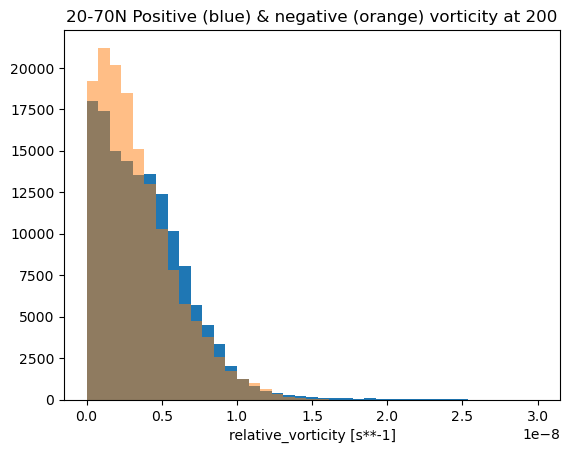

In [47]:
mylev = 200

relvor.sel(latitude=slice(70,20),level=mylev).plot.hist(bins=np.linspace(0,3e-8,40) );
(-relvor.sel(latitude=slice(70,20),level=mylev)).plot.hist(bins=np.linspace(0,3e-8,40), alpha=0.5);
plt.title('20-70N Positive (blue) & negative (orange) vorticity at '+str(mylev));

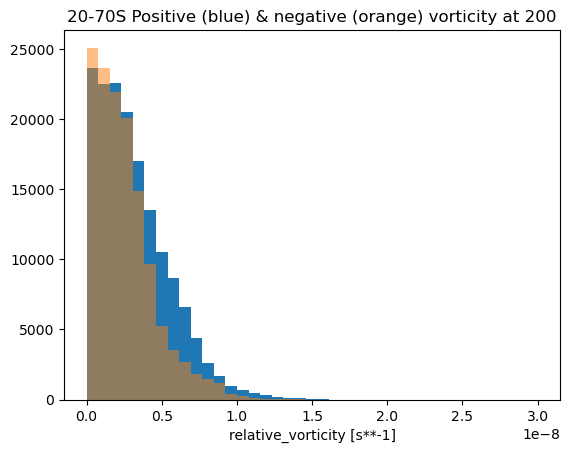

In [48]:
relvor.sel(latitude=slice(-20,-70),level=mylev).plot.hist(bins=np.linspace(0,3e-8,40) );
(-relvor.sel(latitude=slice(-20,-70),level=mylev)).plot.hist(bins=np.linspace(0,3e-8,40), alpha=0.5);
plt.title('20-70S Positive (blue) & negative (orange) vorticity at '+str(mylev));

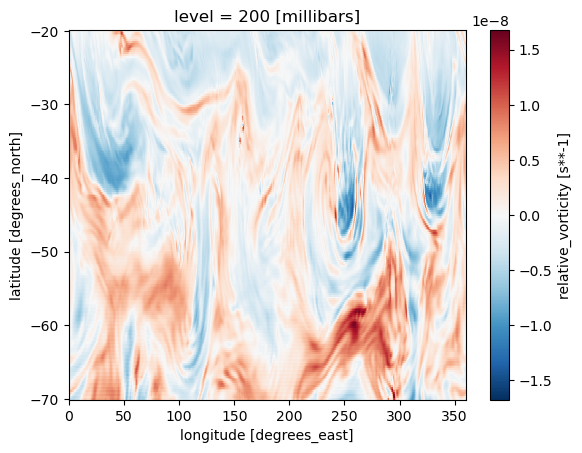

In [49]:
relvor.sel(latitude=slice(-20,-70),level=mylev).plot()